# Cooling model Monte Carlo Analysis

- core and rim ages are associated with errors
- the idea is to demonstrate how those errors propagate into the cooling rate and starting temperature calculation
- create a random sample of core and rim ages based on a Gaussian distribution of values around the mean ages with a standard deviation defined by the errors
- feed the random ages into the aggregation and cooling model to obtain a distribution of cooling rates and starting temperatures
- plot results

## Define Functions
These functions will be used in the modelling below

In [93]:
import numpy as np

def Temp_N(t, NT, IaB):
    """
    calculate T in Celsius based on nitrogen aggregation
    INPUT:
        t: age in (seconds)
        NT: total Nitrogen concentration (ppm)
        IaB: proportion of B-centres (0 to 1)

    RETURNS:
        T: temperature (Celsius)
    """   
    NA = NT * (1-IaB)
    T = (-81160/(np.log(((NT/NA)-1)/(t*NT*293608))))

    return T-273

def aggregate(NA, T, t):
    """
    Calculate nitrogen aggregation for a given temperature and duration

    INPUT:
    NA: initial nitrogen in A-centres (ppm)
    T: temperature (Celsius)
    t: duration (Ma)
    
    RETURNS:
    NA_final: final nitrogen in A-centres (ppm)
    """
    EaR = 81160
    preexp = 293608
    rate_const = preexp * np.exp(-EaR/(T+273))
    
    NA_final = NA/(1 + rate_const * t * NA)

    return NA_final

def linear_cool(T_start, time, rate):
    """Calculate the temperature after a given time (t) of linear cooling from a given T_start at a given rate"""

    return T_start - time * rate

def aggregate_and_cool(params, *args):
    """"
    Function used in the optimization of the cooling rate and starting
    temperature of a sample to match the observed nitrogen aggregation data
    
    INPUT:
    params: tuple of parameters to be optimized
        T_start: starting temperature (Celsius)
        cooling_rate: cooling rate (Celsius/Ma)
    args: tuple of arguments for the aggregation function
        durations: list of durations (Ma)
        age_core: age of the core (Ma)
        age_rim: age of the rim (Ma)
        c_NT: total nitrogen concentration in the core (ppm)
        r_NT: total nitrogen concentration in the rim (ppm)
        c_agg: observed nitrogen aggregation in the core
        r_agg: observed nitrogen aggregation in the rim
    
    RETURNS:
    error: sum of the squared differences between the modelled and observed nitrogen aggregation values
    """
    # unpack parameters and arguments
    T_start, cooling_rate = params
    
    durations = args[0]
    age_core= args[1]
    age_rim= args[2]
    c_NT= args[3]
    r_NT= args[4]
    c_agg= args[5]
    r_agg= args[6]
       
    # initialize variables
    c_NA0 = c_NT
    c_NA1 = 0
    r_NA0 = r_NT
    r_NA1 = 0
        
    NA_core = []
    NA_rim = []
    T_all = []
    
    # iterate over the cooling steps
    i = 0    
    for duration in durations:
        # calculate T for each duration
        T = linear_cool(T_start, duration, cooling_rate)

        # work out duration increment from duration list
        if i == 0:
            d_t = duration
        else:
            d_t = durations[i]-durations[i-1]
    
        # before rim grows, only core aggregates:
        if (age_core - duration) > age_rim:
            c_NA1 = aggregate(c_NA0, T, d_t * 1e6 * 365.25 * 24 * 60 * 60)
            c_NA0 = c_NA1
        
        # after rim has grown, core and rim now both aggregate
        elif (age_core - duration) < age_rim:
            c_NA1 = aggregate(c_NA0, T, d_t * 1e6 * 365.25 * 24 * 60 * 60)
            c_NA0 = c_NA1
        
            r_NA1 = aggregate(r_NA0, T, d_t * 1e6 * 365.25 * 24 * 60 * 60)
            r_NA0 = r_NA1
    
        # increment i and append values to lists
        # it may not be necessary to store all values, but might be useful for debugging/plotting
        i += 1
        NA_core.append(c_NA0)
        NA_rim.append(r_NA0)
        T_all.append(T)

    # retrieve final aggregation values
    c_agg_model = 1-(NA_core[-1]/c_NT)
    r_agg_model = 1-(NA_rim[-1]/r_NT)       
            
    # calculate error
    # multiplying by 1000 for scaling purposes. It ain't stupid if it works, right?
    error = ((r_agg - r_agg_model)**2 + (c_agg - c_agg_model)**2)*1e3

    return error


## Aggregation and Cooling Model

### Define parameters
#### 1. Parameters relating to the sample

In [ ]:
# Define parameters
# Diamond properties
# ages and standard deviations in Ma:
age_core = 3520
stdev_core = 170
age_rim = 1860
stdev_rim = 190
age_kimberlite = 0

# Nitrogen data (total N concentration in ppm and proportion of B-centres 0-1):
# core:
c_NT = 625
c_agg = 0.863

# rim:
r_NT = 801
r_agg = 0.197


#### 2. Parameters used in the forward model

In [99]:
# number of samples drawn randomly, i.e. number of iterations for the model, e.g. 1000
numsamp = 1000

# time step in Ma, e.g. 1 Ma
dt = 1

# first guess for starting temperature and cooling rate:
cooling_rate0 = 0.01 
T_start0 = 1200
# (200 degC/Ga = 0.2 degC/Ma)

# boundaries for starting Temperature:
T_bounds = (1000, 1450)

# boundaries for cooling rate:
rate_bounds = (0.001, 0.12)

# location to save results
savename = 'cooling_aggregation_results.csv'


### Run model

In [ ]:
import numpy as np
import scipy.optimize as op

# draw numsamp amount of random ages from normal distribution:
draw_core = np.random.normal(age_core, stdev_core, numsamp)
draw_rim = np.random.normal(age_rim, stdev_rim, numsamp)

# initialise variables to store data
start_T = np.zeros(numsamp)
cooling_rate = np.zeros(numsamp)

results = dict.fromkeys(range(numsamp))


# loop through the samples and run the forward model
for i in range(numsamp):

    # retrieve core and rim ages from random sample
    age_core = draw_core[i] 
    duration_core = age_core - age_kimberlite
    age_rim = draw_rim[i]
    duration_rim = age_rim - age_kimberlite

    # set up time steps for the forward model
    durations = np.arange(0., duration_core+1, dt)
    durations[0] = 0.01

    if durations[-1] < duration_core:
        durations = np.append(durations, duration_core)
    else:
        durations[-1] = duration_core

    # print some stuff so we know what is going on
    print(f"Iteration {i+1}/{numsamp}")
    print("Starting forward model with the following parameters:")
    print(f" - total duration: {np.round(duration_core)} Ma")
    print(f" - rim duration: {np.round(duration_rim)} Ma")
    print(f" - time step {dt} Ma")

    # run the forward model, find starting T and cooling rate for the given parameters
    res = op.minimize(
        aggregate_and_cool,
        x0=(T_start0, cooling_rate0),
        bounds=(T_bounds, rate_bounds),
        args=(durations, age_core, age_rim, c_NT, r_NT, c_agg, r_agg),
        tol=1e-6
        )
    
    # store results
    start_T[i]=res.x[0]
    cooling_rate[i]=res.x[1]

    res['Starting T'] = res.x[0]
    res['Cooling rate'] = res.x[1]
    res['Core duration'] = duration_core
    res['Rim duration'] = duration_rim
    results[i] = res
    
    # print results
    print("Forward model finished. Results:")
    print(f' - Success: {res.success}\nmessage: {res.message}')
    print(f' - Status: {res.status}')
    print(f' - Starting T: {np.round(res.x[0],0)}\ncooling rate: {res.x[1]}')
    print(50 * '-')


Iteration 1/1000
Starting forward model with the following parameters:
 - total duration: 3498.0 Ma
 - rim duration: 1471.0 Ma
 - time step 1 Ma
Forward model finished. Results:
 - Success: True
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 - Status: 0
 - Starting T: 1211.0
cooling rate: 0.041807982156785946
--------------------------------------------------
Iteration 2/1000
Starting forward model with the following parameters:
 - total duration: 3891.0 Ma
 - rim duration: 1821.0 Ma
 - time step 1 Ma
Forward model finished. Results:
 - Success: True
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 - Status: 0
 - Starting T: 1210.0
cooling rate: 0.04126853913253197
--------------------------------------------------
Iteration 3/1000
Starting forward model with the following parameters:
 - total duration: 3764.0 Ma
 - rim duration: 1893.0 Ma
 - time step 1 Ma
Forward model finished. Results:
 - Success: True
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 - 

### Save data

In [ ]:
import pandas as pd

# save results to csv
df = pd.DataFrame.from_dict(results, orient='index')
df.to_csv(savename)

## Read data (e.g. previous results)

In [ ]:
import pandas as pd

loadname = 'cooling_aggregation_results.csv'
df = pd.read_csv(loadname)

## Filter data

In [161]:
# set up some filters
rate_bounds = (0.001, 0.3)
T_bounds = (1000, 1450)

# make sure cooling rate and starting temperature are within bounds
rate_filter = df['Cooling rate'].between(rate_bounds[0], rate_bounds[1])
T_filter = df['Starting T'].between(T_bounds[0], T_bounds[1])

# make sure core duration is greater than rim duration
sensible_ages = df['Core duration'] > df['Rim duration']

# group all filters together
filters = rate_filter & T_filter & sensible_ages

# work out and print how many samples will be removed
print(f"Number of samples before filtering: {len(df)}")

print(f"Total number of samples removed: {len(df) - len(df[filters])}")
print(f"- cooling rate out of bounds: {len(df[~rate_filter])}")
print(f"- starting temperature out of bounds: {len(df[~T_filter])}")
print(f"- core younger than rim: {len(df[~sensible_ages])}")
print(f"Number of samples after filtering: {len(df[filters])}")

# apply filters
df = df[filters]

Number of samples before filtering: 9617
Total number of samples removed: 0
- cooling rate out of bounds: 0
- starting temperature out of bounds: 0
- core younger than rim: 0
Number of samples after filtering: 9617


## Plot stuff

### 1. Histograms

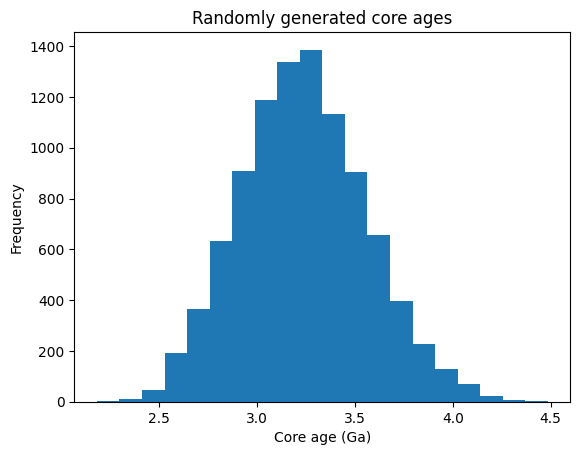

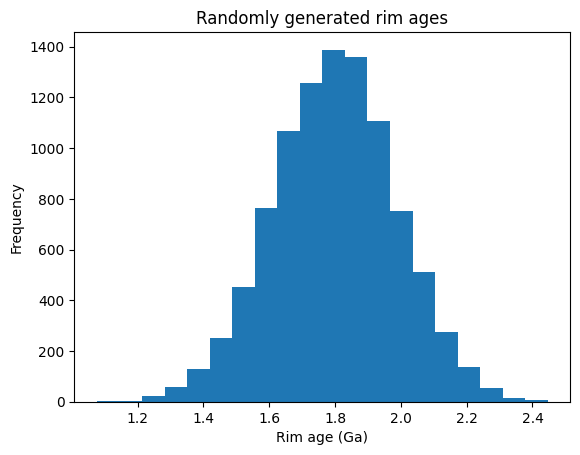

In [ ]:
import matplotlib.pyplot as plt

# number of bins to be used in the histograms
bins = 20

# Plot core ages
plt.figure()
h1 = plt.hist(1e-3*df['Core duration'], bins=bins)
plt.xlabel('Core age (Ga)')
plt.ylabel('Frequency')
plt.title('Randomly generated core ages')
plt.show()

# Plot rim ages
plt.figure()
plt.hist(1e-3*df['Rim duration'], bins=bins)
plt.xlabel('Rim age (Ga)')
plt.ylabel('Frequency')
plt.title('Randomly generated rim ages')
plt.show()

Basic stats based on data:
Number of samples: 9617
Cooling rate: 65.2 +/- 18.7 C/Ga
Starting temperature: 1206.0 +/- 7.0 C


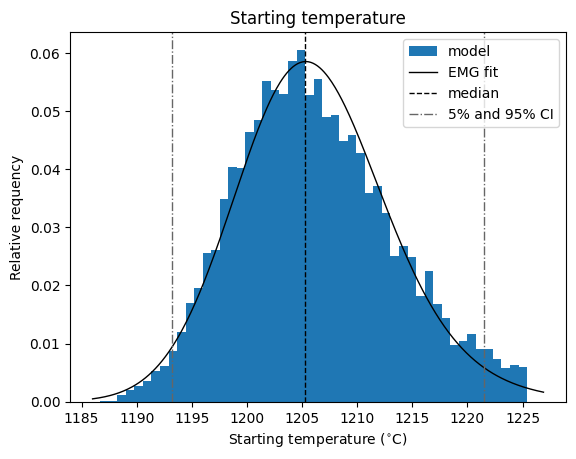

Stats for starting temperature (based on EMG fit):
- mean: 1206.2393527653335
- mode: 1205.882440746421
- skew: 0.3899160799831841
- variance: 51.342930858414654
- std: 7.165398164681057
- 95% CI: (1193.194952348975, 1221.4710379513538)
- median: 1205.2999999999824
- weighted mean: 1206.089269237397


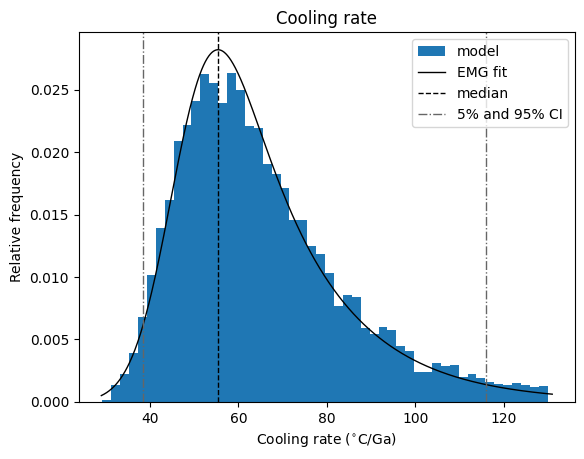

Stats for cooling rate (based on EMG fit):
- mean: 65.17434417408613
- mode: 60.948821687867394
- skew: 1.5635302104071496
- variance: 394.2385484715819
- std: 19.855441281210094
- 95% CI: (38.48562099012686, 115.988040954313)
- median: 55.400000000000375
- weighted mean: 64.28543578254481


In [ ]:
# Histograms and EMG fits of starting temperature and cooling rate
import numpy as np
from scipy.stats import exponnorm
import matplotlib.pyplot as plt

def get_stats(exponnorm_fit_params):
    return {
        'mean': exponnorm.mean(*exponnorm_fit_params),
        'mode': exponnorm.median(*exponnorm_fit_params),
        'skew': exponnorm.stats(*exponnorm_fit_params, moments='s'),
        'variance': exponnorm.var(*exponnorm_fit_params),
        'std': exponnorm.std(*exponnorm_fit_params),
        '95% CI': exponnorm.interval(0.95, *exponnorm_fit_params)}

# print some basic statistics
print('Basic stats based on data:')
print(f"Number of samples: {len(df)}")
print(f"Cooling rate: {np.round(np.mean(1e3*df['Cooling rate']),1)} +/- {np.round(np.std(1e3*df['Cooling rate']),1)} C/Ga")
print(f"Starting temperature: {np.round(np.mean(df['Starting T']),0)} +/- {np.round(np.std(df['Starting T']),0)} C")

# fit an exponentially modified Gaussian to the starting temperature data
T_fit_params = exponnorm.fit(df['Starting T'])
T_vals = np.arange(int(np.floor(min(df['Starting T']))), int(np.ceil(max(df['Starting T'])))+1, 0.1)
T_fit = exponnorm.pdf(T_vals, *T_fit_params)

# calculate statistics for the fitted distribution
T_stats = get_stats(T_fit_params)
T_median = T_vals[np.argmax(T_fit)]
T_weighted = np.average(T_vals, weights=T_fit)

# fit an exponentially modified Gaussian to the cooling rate data
rate_fit_params = exponnorm.fit(1e3*df['Cooling rate'])
rate_vals = np.arange(int(np.floor(min(1e3*df['Cooling rate']))), int(np.ceil(max(1e3*df['Cooling rate'])))+1, 0.1)
rate_fit = exponnorm.pdf(rate_vals, *rate_fit_params)

# calculate statistics for the fitted distribution
rate_stats = get_stats(rate_fit_params)
rate_median = rate_vals[np.argmax(rate_fit)]
rate_weighted = np.average(rate_vals, weights=rate_fit)

# number of bins to be used in the histograms
num_bins = 50

# Plot starting temperatures
plt.figure()
plt.hist(df['Starting T'], bins=num_bins, density=True, label='model')
plt.plot(T_vals, T_fit, 'k-', lw=1, label='EMG fit')
plt.axvline(x=T_median, color='k', lw=1, ls='--', label='median')
plt.axvline(x=T_stats['95% CI'][0], color='0.4', lw=1, ls='-.')
plt.axvline(x=T_stats['95% CI'][1], color='0.4', lw=1, ls='-.', label='5% and 95% CI')
plt.legend()
plt.xlabel('Starting temperature ($^{\circ}$C)')
plt.ylabel('Relative requency')
plt.title('Starting temperature')
plt.show()

# print some statistics for the fitted distributions
print('Stats for starting temperature (based on EMG fit):')
for key, value in T_stats.items():
    print(f'- {key}: {value}')
print(f'- median: {T_median}')
print(f'- weighted mean: {T_weighted}')

# Plot cooling rates
plt.figure()
plt.hist(1e3*df['Cooling rate'], bins=num_bins, density=True, label='model')
plt.plot(rate_vals, rate_fit, 'k-', lw=1, label='EMG fit')
plt.axvline(x=rate_median, color='k', lw=1, ls='--', label='median')
plt.axvline(x=rate_stats['95% CI'][0], color='0.4', lw=1, ls='-.')
plt.axvline(x=rate_stats['95% CI'][1], color='0.4', lw=1, ls='-.', label='5% and 95% CI')
plt.legend()
plt.xlabel('Cooling rate ($^{\circ}$C/Ga)')
plt.ylabel('Relative frequency')
plt.title('Cooling rate')
plt.show()

# print some statistics for the fitted distributions
print('Stats for cooling rate (based on EMG fit):')
for key, value in rate_stats.items():
    print(f'- {key}: {value}')
print(f'- median: {rate_median}')
print(f'- weighted mean: {rate_weighted}')



### 2. Plot correlations

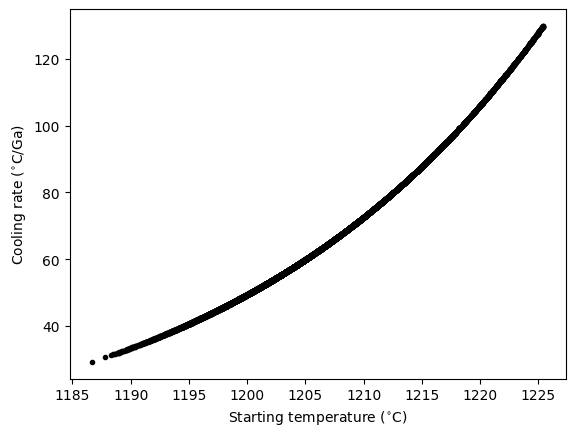

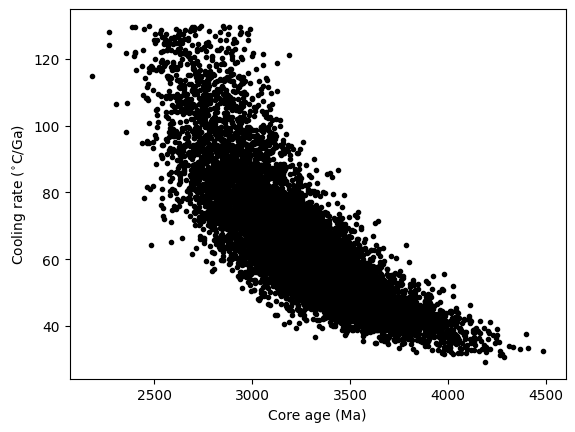

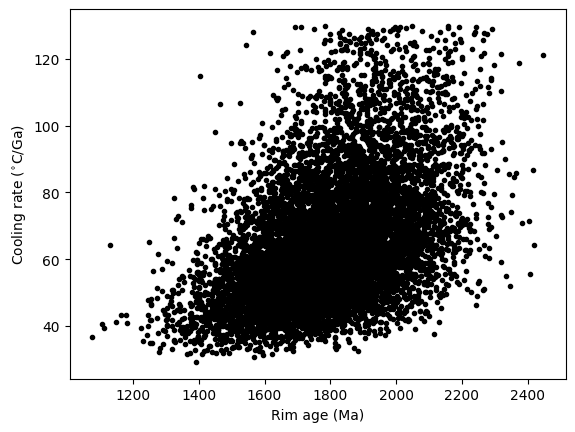

In [ ]:
# Correlations (simple scatter plots)
import matplotlib.pyplot as plt

# marker options for plotting
marker = 'ko'
markersize = 3

# Plot starting temperature vs cooling rate
plt.figure()
plt.plot(df['Starting T'], 1e3*df['Cooling rate'], marker, markersize=markersize)
plt.xlabel('Starting temperature ($^{\circ}$C)');
plt.ylabel('Cooling rate ($^{\circ}$C/Ga)');
#plt.xlim([1190,1240])
#plt.ylim([20,110])

plt.figure()
#plt.subplot(121)
plt.plot(df['Core duration'], 1e3*df['Cooling rate'], marker, markersize=markersize)
plt.xlabel('Core age (Ma)');
plt.ylabel('Cooling rate ($^{\circ}$C/Ga)');

plt.figure()
plt.plot(df['Rim duration'], 1e3*df['Cooling rate'], marker, markersize=markersize)
plt.xlabel('Rim age (Ma)');
plt.ylabel('Cooling rate ($^{\circ}$C/Ga)');

### 3. Correlations with Gaussien kernel estimation ( = estimate of data density)

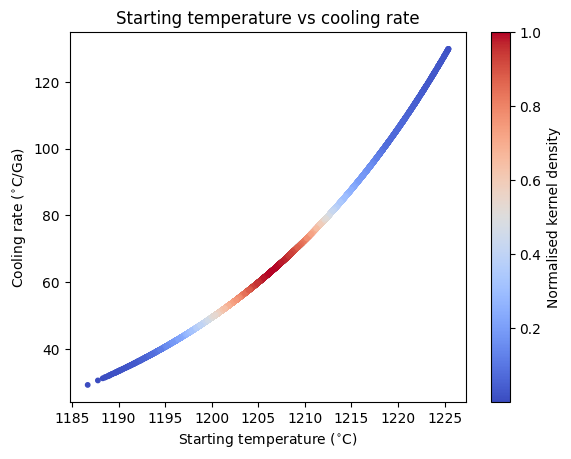

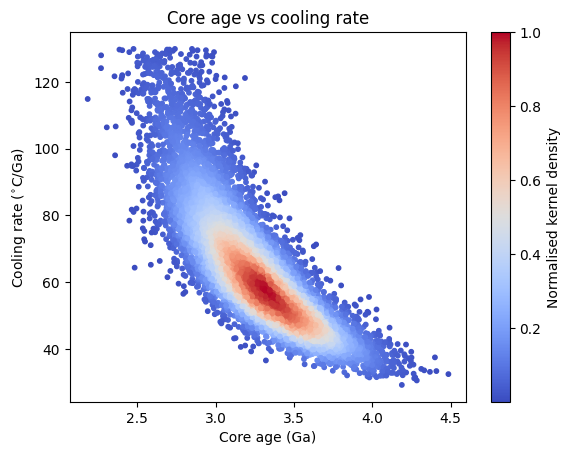

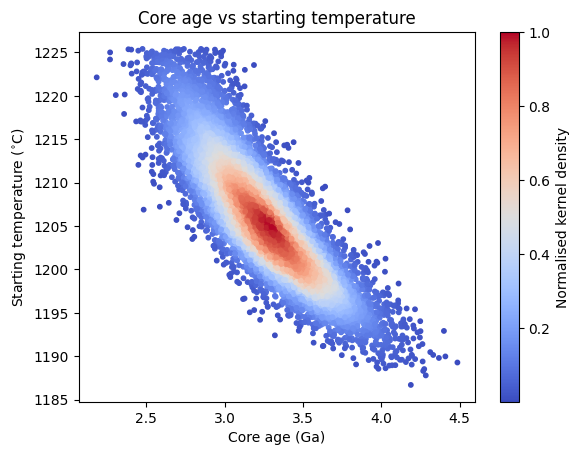

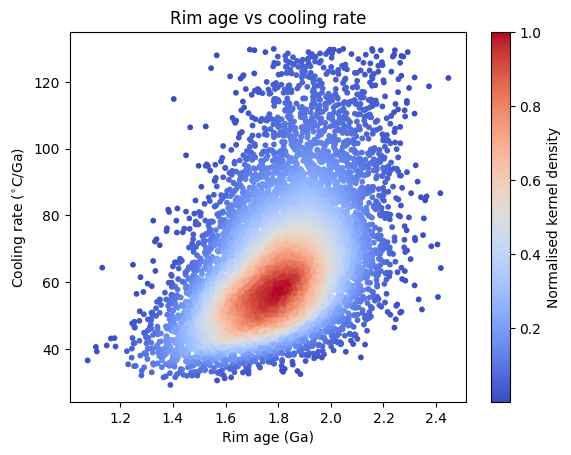

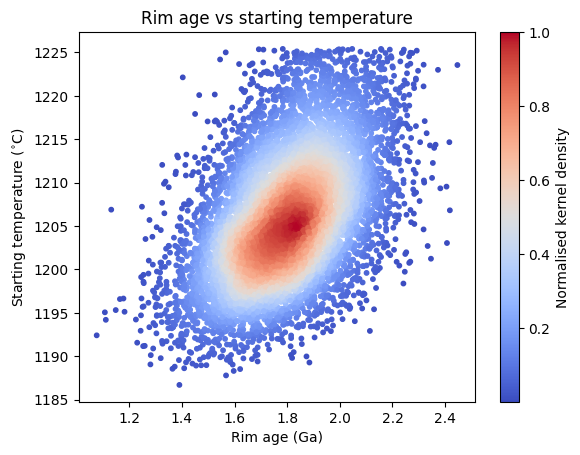

In [160]:
# Correlations (kernel density plots)
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# colourmap and marker sizes
colormap = plt.cm.coolwarm
sizes = np.ones(numsamp)*10

# Cooling rate vs starting temperature
# Calculate the point density
rate_T = np.vstack([df['Cooling rate'], df['Starting T']])
rate_T_kde = gaussian_kde(rate_T)(rate_T)
rate_T_kde = rate_T_kde / np.max(rate_T_kde)

plt.figure()
plt.scatter(df['Starting T'], 1e3*df['Cooling rate'], c=rate_T_kde, cmap=colormap, sizes=sizes)
plt.xlabel('Starting temperature ($^{\circ}$C)')
plt.ylabel('Cooling rate ($^{\circ}$C/Ga)')
plt.colorbar(label='Normalised kernel density')
plt.title('Starting temperature vs cooling rate');


# Core age vs cooling rate
# Calculate the point density
core_rate = np.vstack([df['Core duration'], df['Cooling rate']])
cr_kde = gaussian_kde(core_rate)(core_rate)
cr_kde = cr_kde / np.max(cr_kde)

# plot
plt.figure()
plt.scatter(1e-3*df['Core duration'], 1e3*df['Cooling rate'], c=cr_kde, cmap=colormap, sizes=sizes)
plt.xlabel('Core age (Ga)')
plt.ylabel('Cooling rate ($^{\circ}$C/Ga)')
plt.colorbar(label='Normalised kernel density')
plt.title('Core age vs cooling rate');

# Core age vs starting temperature
# Calculate the point density
core_T = np.vstack([df['Core duration'], df['Starting T']])
cT_kde = gaussian_kde(core_T)(core_T)
cT_kde = cT_kde / np.max(cT_kde)

# plot
plt.figure()
plt.scatter(1e-3*df['Core duration'], df['Starting T'], c=cT_kde, cmap=colormap, sizes=sizes)
plt.xlabel('Core age (Ga)')
plt.ylabel('Starting temperature ($^{\circ}$C)')
plt.colorbar(label='Normalised kernel density')
plt.title('Core age vs starting temperature');

# Rim age vs cooling rate
# Calculate the point density
rim_rate = np.vstack([df['Rim duration'], df['Cooling rate']])
rr_kde = gaussian_kde(core_rate)(core_rate)
rr_kde = rr_kde / np.max(rr_kde)

# plot
plt.figure()
plt.scatter(1e-3*df['Rim duration'], 1e3*df['Cooling rate'], c=rr_kde, cmap=colormap, sizes=sizes)
plt.xlabel('Rim age (Ga)')
plt.ylabel('Cooling rate ($^{\circ}$C/Ga)')
plt.colorbar(label='Normalised kernel density')
plt.title('Rim age vs cooling rate');

# Rim age vs starting temperature
# Calculate the point density
rim_T = np.vstack([df['Rim duration'], df['Starting T']])
rT_kde = gaussian_kde(rim_T)(rim_T)
rT_kde = rT_kde / np.max(rT_kde)

# plot
plt.figure()
plt.scatter(1e-3*df['Rim duration'], df['Starting T'], c=rT_kde, cmap=colormap, sizes=sizes)
plt.xlabel('Rim age (Ga)')
plt.ylabel('Starting temperature ($^{\circ}$C)')
plt.colorbar(label='Normalised kernel density')
plt.title('Rim age vs starting temperature');